# 1- Imports
# 2- Data Exploration
# 3- Preprocessing
# 4- Model
# Conclusion

# 1- Imports

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd
import tensorflow as tf

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

from IPython.display import Image

In [2]:
# Importing the dataset
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", encoding =  "ISO-8859-1")

# 2- Data Exploration

In [3]:
# Displaying basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print("Number of columns : {}".format(dataset.shape[1]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 5572
Number of columns : 5

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [4]:
# As we can see many Nans on columns 2, 3 and 4, checking what are the data in column 4
dataset[dataset['Unnamed: 4'].notna()].head(6)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2255,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and swe..."
3525,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4668,ham,"When I was born, GOD said, \Oh No! Another IDI...",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!"""
5048,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""


In [5]:
# Columns 2 , 3 and 4 are part of the message that was divided into 4 columns.
# Creating a new column to concatenate all text columns and dropping the useless ones
dataset['text'] = dataset['v2'].fillna('') + " " + dataset['Unnamed: 2'].fillna('') + " " + dataset['Unnamed: 3'].fillna('') + " " + dataset['Unnamed: 4'].fillna('')

useless_cols = [ 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
dataset = dataset.drop(useless_cols, axis=1)

dataset.head()

,v1,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Column "v1" is the label : "ham" means honest message, and "spam" are the ones we need to detect.
# Checking the proportion of spams on the dataset
fig = px.pie(dataset, names="v1", title="Spam Ratio", hole=0.4,
            color=dataset["v1"],
            color_discrete_map={'ham':'green','spam':'red'})
fig.update_layout(title_x=0.48)
fig.update_traces(textinfo="value+percent")
fig.show()

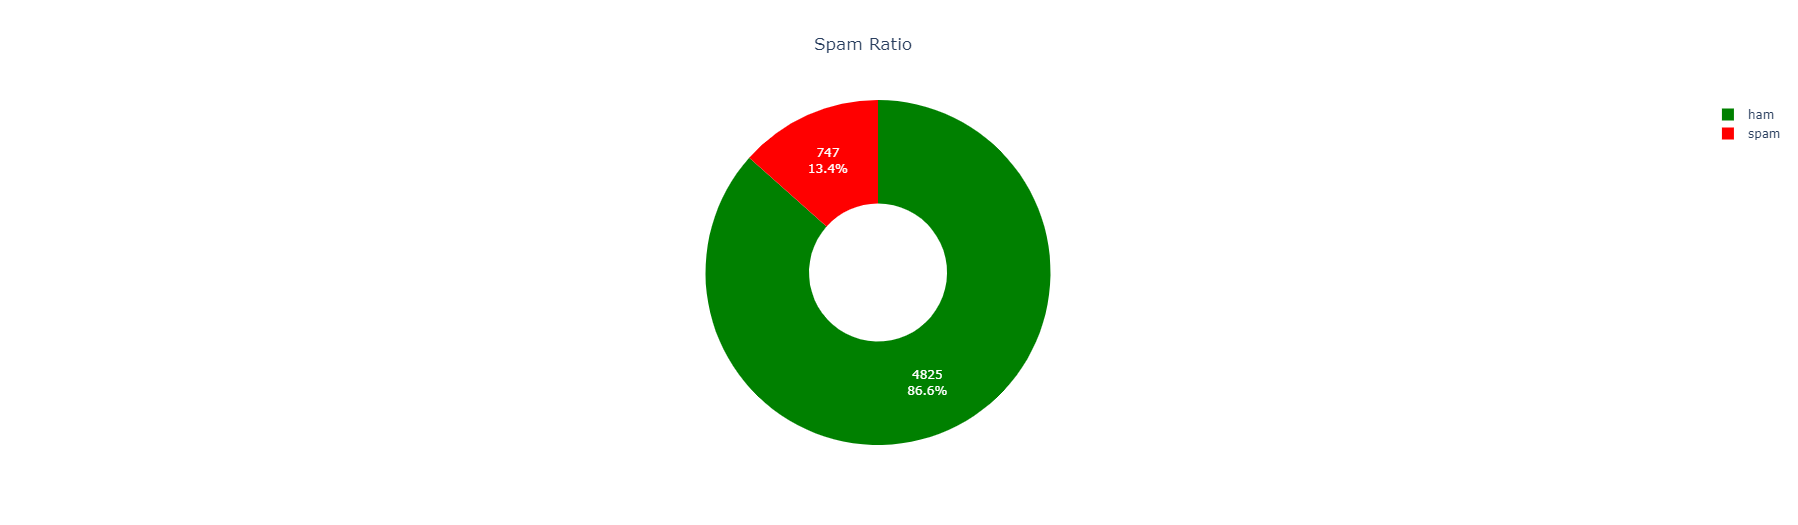

In [7]:
Image(filename='pie-spam-ratio.png') 

# 3- Preprocessing

In [8]:
# Manually encoding the target column with 0 and 1
dataset['target'] = dataset['v1'].apply(lambda x: 0 if x == 'ham' else 1)
dataset = dataset.drop("v1", axis=1)
dataset

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will Ì_ b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [9]:
# Downloading English packages
import en_core_web_sm
nlp = en_core_web_sm.load()

# Importing English Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [10]:
# Removing all non alphanumeric characters except whitespaces
dataset["text_clean"] = dataset["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# Removing double spaces and spaces at the beginning and end of strings
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# Removing stop words and replacing every word with their lemma
dataset["text_clean"] = dataset["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [11]:
# Encoding words
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="UNKNOWN_WORD") # will replace any unknown word by this
tokenizer.fit_on_texts(dataset['text_clean'])
dataset['text_clean_encoded'] = tokenizer.texts_to_sequences(dataset['text_clean'])

# Sometimes the preprocessing removes all the words in a string (because they contain only stopwords for example) so we calculate the length in order to filter out those records
dataset["len_text"] = dataset["text_clean_encoded"].apply(lambda x: len(x))
dataset = (dataset[dataset["len_text"]!=0]).reset_index()
dataset.head()

,index,text,target,text_clean,text_clean_encoded,len_text
0,0,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[3625, 234, 447, 462, 948, 36, 53, 206, 949, 8...",14
1,1,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni,"[10, 194, 3627, 291, 2, 1461]",6
2,2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...,"[13, 301, 4, 536, 660, 34, 1462, 859, 424, 146...",22
3,3,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[2, 126, 151, 2379, 2, 86]",6
4,4,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live,"[711, 23, 661, 129]",4


In [12]:
# Padding sequences for them to have the same length
dataset_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset['text_clean_encoded'], padding="post")

In [13]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(dataset_pad,dataset['target'], test_size=0.2, random_state= 7, stratify = dataset['target'])

In [14]:
# Creating tensors
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [15]:
# Creating batches
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

# 4- Model

In [16]:
# Creating our Deep Learning model
vocab_size = tokenizer.num_words
embedding_dim = 128

model = Sequential([         
                  Embedding(vocab_size+1, embedding_dim,name="embedding"), # Word Embedding layer
                  GlobalAveragePooling1D(), # Gobal average pooling
                  Dense(64, activation='relu'), # Dense layer
                  Dense(32, activation='relu'), # Dense layer
                  Dense(1, activation="sigmoid") # Prediction layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280128   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,290,497
Trainable params: 1,290,497
Non-trainable params: 0
______________________________________________

In [17]:
# Compiling with loss and metrics
model.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [18]:
# Calcultaing weight since the dataset is unbalanced with much more 0 (ham) than 1 (spam)
weights = 1/(dataset["target"]).value_counts()
weights = weights * len(dataset)/5
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.23107321131447586, 1: 1.4872824631860777}

In [19]:
# Lauching model
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch,
                    class_weight=weights)

Epoch 1/20
70/70 [==============================] - 13s 148ms/step - loss: 0.2730 - accuracy: 0.8616 - val_loss: 0.5925 - val_accuracy: 0.8956
Epoch 2/20
70/70 [==============================] - 7s 99ms/step - loss: 0.1968 - accuracy: 0.9507 - val_loss: 0.1722 - val_accuracy: 0.9748
Epoch 3/20
70/70 [==============================] - 3s 49ms/step - loss: 0.0600 - accuracy: 0.9865 - val_loss: 0.0977 - val_accuracy: 0.9829
Epoch 4/20
70/70 [==============================] - 2s 33ms/step - loss: 0.0309 - accuracy: 0.9917 - val_loss: 0.1048 - val_accuracy: 0.9775
Epoch 5/20
70/70 [==============================] - 2s 29ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 0.0449 - val_accuracy: 0.9883
Epoch 6/20
70/70 [==============================] - 3s 36ms/step - loss: 0.0119 - accuracy: 0.9968 - val_loss: 0.0484 - val_accuracy: 0.9883
Epoch 7/20
70/70 [==============================] - 1s 17ms/step - loss: 0.0088 - accuracy: 0.9966 - val_loss: 0.0473 - val_accuracy: 0.9865
Epoch 8/20


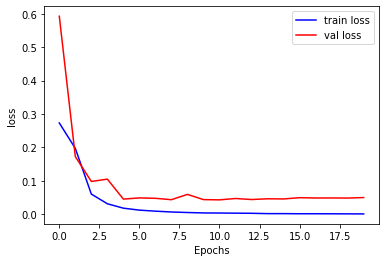

In [20]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b", label="train loss")
plt.plot(history.history["val_loss"], color="r", label="val loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

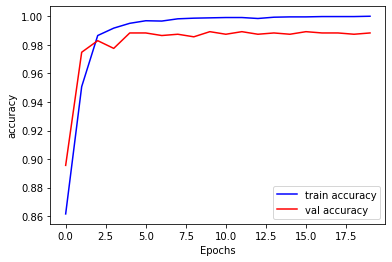

In [21]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b", label="train accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="val accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [22]:
# Checking all results
prediction = model.predict(xval)
classes_pred = [round(pred[0]) for pred in prediction]

print(classification_report(yval, classes_pred))

35/35 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       962
           1       0.99      0.93      0.96       149

    accuracy                           0.99      1111
   macro avg       0.99      0.96      0.97      1111
weighted avg       0.99      0.99      0.99      1111



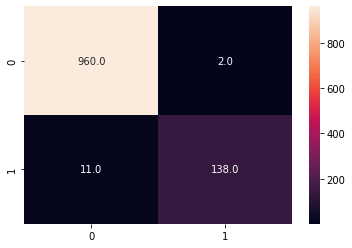

In [23]:
# Visualizing True Positives, True Negatives, False Positives, False Negatives with a confusion matrix
confusion_matrix = confusion_matrix(yval, classes_pred)

sns.heatmap(confusion_matrix, annot = True, fmt=".1f")
plt.show()

# Conclusion

As we can see, our model has a good prediction rate for spam messages: it detected 138 spam out of 149 (96%).
And it did not block too many honest/ham messages: only 2 out of 962 were identified as spam.